In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ROOT
ROOT.gSystem.Load("/Users/guangyongfu/Software/RooUnfold/build/libRooUnfold.dylib")

import pyroounfold
from pyroounfold.toy_unfold import toy_unfold
from pyroounfold.unfold import unfold
from pyroounfold.plotting import *

/Users/guangyongfu/Software/PyRooUnfold/example/rootenv/lib/python3.12/site-packages/pyroounfold/__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


As an example, we create an artificial variable to play. In practical application, this can be skipped and start from reading in actual ntuples/rootfiles as pandas.dataframe. 

In [2]:
# Gaussian smearing function
import ROOT

def smear(xt):
    xsmear= ROOT.gRandom.Gaus(-2.5,0.2)
    return xt+xsmear;


In [24]:
data_sim=np.load("angular_recon_2panels.npz")
cos_true = data_sim['cos_true']
cos_recon = data_sim['cos_recon']

In [25]:
data_measure = np.load("measured_angular.npz")
cos_measured = data_measure['var_align_list']

In [56]:
df_train = pd.DataFrame(columns=['truth','measured', 'weight'])  # dataframe providing migration matrix, e.g. MC
df_test = pd.DataFrame(columns=['truth','measured', 'weight'])   # dataframe providing distribution to be unfolded, e.g. toy MC, or data as 'measured'


df_train['truth'] = cos_true
df_train['measured'] = cos_recon
df_train['weight'] = 1.

df_test['truth'] = cos_measured[0]
df_test['measured'] = cos_measured[0]
df_test['weight'] = 1.

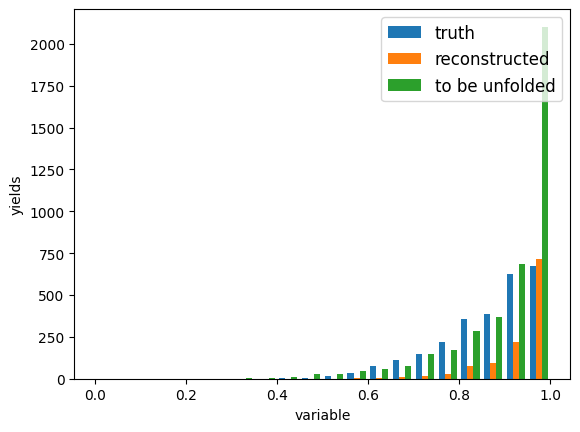

In [57]:
# have a look at the fictional data
my_bins = np.linspace(0,1,21)

plt.hist([df_train['truth'], df_train['measured'], df_test['measured']], 
         label=['truth', 'reconstructed', 'to be unfolded'], bins = my_bins )
plt.xlabel('variable')
plt.ylabel('yields')
plt.legend(loc='upper right', prop={'size':12})
plt.show()
plt.close()

Let's start with the most simple example. No input bin-wise uncertainty or covariance matrix. The default bin error is square root of the bin count.

In [58]:
# define unfold class with all input

example_a = unfold(
    
    df_train = df_train,                     
    weight_train = df_train['weight'], 
    df_test = df_test,                       
    weight_test = df_test['weight'], 
    name_var_true = 'truth', 
    name_var_reco = 'measured',  
    show_var = 'variable',   # just for plotting
    bins = my_bins,
    mc_stat_err = 0
    
    ## optional input
    # reco_bin_error = measured bin-wiese uncertainty
    # reco_cov = measured covariance matrix
    # kcovtoy = if False, error propagation is based on full covariance matrix; 
    #           if True, error propagation is based on internal toys generated by RooUnfold. Default is False. 
    # mc_stat_err = exclude (0) or include (3, default) or only (2) the effect of MC statistics uncertainty on migration matrix evaluated with interal toys.
    )


Now everything needed to launch unfolding is ready !!!

Let's give it a first try, e.g. SVD method with k=0 (default value will be taken by algorithm, i.e. #bins/2)

In [62]:
#example_a.do_Svd(5)
    
#example_a.do_Invert()
example_a.do_BinByBin()

covariance matrix condition=-1, determinant=0, tolerance=2.22045e-16
Inverse covariance matrix 100% maximum error


In [63]:
# unfolded result

example_a.result_df

,bin_index,truth_central,truth_stat_error,measured_central,measured_error,unfolded_central,unfolded_error,coverage_perbin
0,0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
1,1,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2,2,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
3,3,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
4,4,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
5,5,1.0,1.000000,1.0,1.000000,0.000000,0.000000,0.000000
6,6,6.0,2.449490,6.0,2.449490,0.000000,0.000000,0.000000
7,7,7.0,2.645751,7.0,2.645751,0.000000,0.000000,0.000000
8,8,13.0,3.605551,13.0,3.605551,0.000000,0.000000,0.000000
9,9,26.0,5.099020,26.0,5.099020,182.000000,35.693137,0.682555


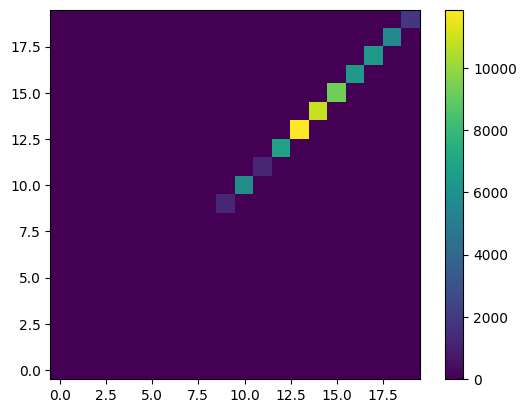

In [64]:
# post-unfold covariance matrix

cov = example_a.result_cov

plt.imshow(cov, origin='lower')
plt.colorbar()
plt.show()

Now we plot the unfolded result comparing with the truth and check the confidence intervals converag, variance and bias for each bin.

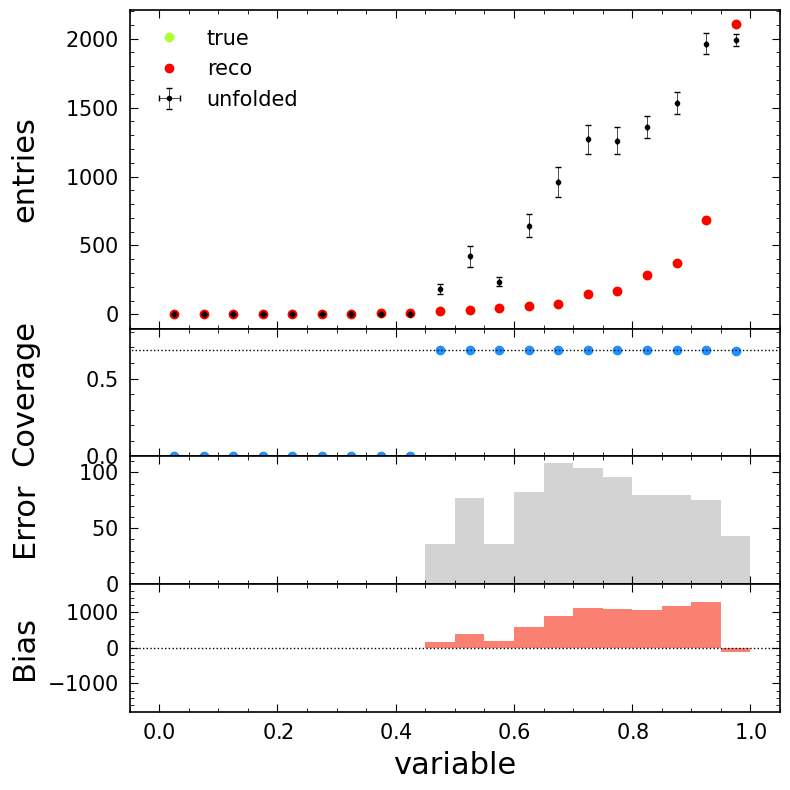

In [65]:
fig = plot_compare_single_run_check(example_a.result_df, my_bins, 'variable', 'entries')

Try other methods..

In [66]:
example_a.do_Svd(30)
unf_cen_svd = example_a.result_df['unfolded_central'].copy()
unf_err_svd = example_a.result_df['unfolded_error'].copy()

example_a.do_Svd(2)
unf_cen_svd_low = example_a.result_df['unfolded_central'].copy()
unf_err_svd_low = example_a.result_df['unfolded_error'].copy()

example_a.do_Invert()
unf_cen_inv = example_a.result_df['unfolded_central'].copy()
unf_err_inv = example_a.result_df['unfolded_error'].copy()

example_a.do_BinByBin()
unf_cen_byb = example_a.result_df['unfolded_central'].copy()
unf_err_byb = example_a.result_df['unfolded_error'].copy()

example_a.do_Bayes(10)
unf_cen_bay = example_a.result_df['unfolded_central'].copy()
unf_err_bay = example_a.result_df['unfolded_error'].copy()

example_a.do_GP()
unf_cen_gp = example_a.result_df['unfolded_central'].copy()
unf_err_gp = example_a.result_df['unfolded_error'].copy()


ERROR: Svd method do not work when regularisation number > nbins.
covariance matrix condition=-1, determinant=0, tolerance=2.22045e-16
Inverse covariance matrix 100% maximum error
covariance matrix condition=-1, determinant=0, tolerance=2.22045e-16
Inverse covariance matrix 100% maximum error
Using response matrix priors
Priors:

Vector (20)  is as follows

     |        1  |
------------------
   0 |0 
   1 |0 
   2 |0 
   3 |0 
   4 |0 
   5 |0 
   6 |0 
   7 |0 
   8 |0.000753864 
   9 |0.00263852 
  10 |0.00527704 
  11 |0.0139465 
  12 |0.027893 
  13 |0.0418394 
  14 |0.0546551 
  15 |0.082925 
  16 |0.134942 
  17 |0.145496 
  18 |0.234828 
  19 |0.254806 

Now unfolding...
Iteration : 0
Chi^2 of change 860.429
Iteration : 1
Chi^2 of change 13.4982
Iteration : 2
Chi^2 of change 1.41948
Iteration : 3
Chi^2 of change 0.57377
Iteration : 4
Chi^2 of change 0.334574
Iteration : 5
Chi^2 of change 0.208085
Iteration : 6
Chi^2 of change 0.131127
Iteration : 7
Chi^2 of change 0.0829525
I

Error in <TDecompLU::InvertLU>: matrix is singular, 1 diag elements < tolerance of 2.2204e-16
Error in <TDecompLU::InvertLU>: matrix is singular, 1 diag elements < tolerance of 2.2204e-16
Error in <TDecompLU::InvertLU>: matrix is singular, 1 diag elements < tolerance of 2.2204e-16
Error in <TDecompLU::InvertLU>: matrix is singular, 1 diag elements < tolerance of 2.2204e-16


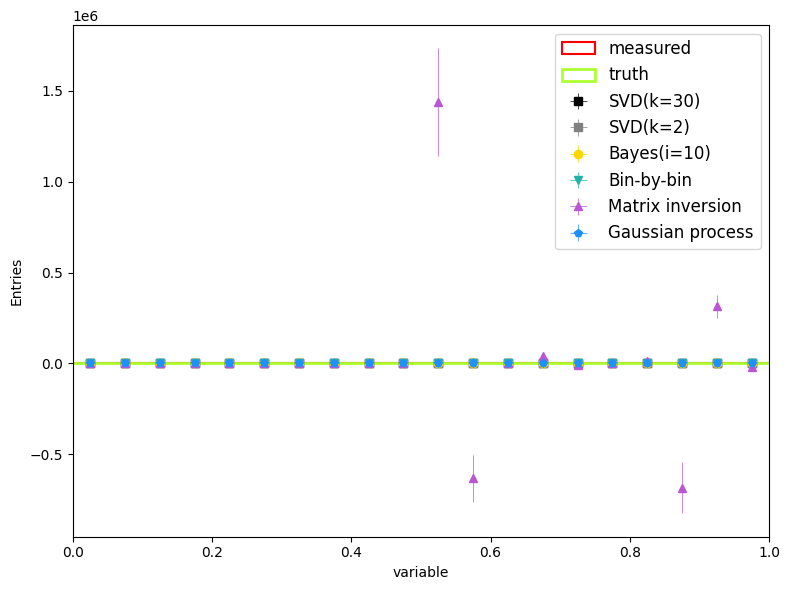

In [67]:
truth_cen = example_a.result_df['truth_central']
measu_cen, measu_err = example_a.result_df['measured_central'], example_a.result_df['measured_error']

f = plt.figure(figsize=(8,6))
plt.hist(get_bin_centers(my_bins), bins=my_bins, weights=measu_cen, histtype='step', lw=1.5, color='red', label='measured')
plt.bar(get_bin_centers(my_bins), height=measu_err*2, width=get_bin_widths(my_bins), bottom=measu_cen - measu_err,
       alpha=0.2, color='red')  

plt.hist(get_bin_centers(my_bins), bins=my_bins, weights=truth_cen, histtype='step', lw=2, color='greenyellow',  label='truth')

plt.errorbar(x=get_bin_centers(my_bins), y=unf_cen_svd, yerr=unf_err_svd, xerr=0, marker='s', color='black',ls='', elinewidth=0.5,  label='SVD(k=30)')
plt.errorbar(x=get_bin_centers(my_bins), y=unf_cen_svd_low, yerr=unf_err_svd_low, xerr=0, marker='s', color='gray',ls='', elinewidth=0.5, label='SVD(k=2)')
plt.errorbar(x=get_bin_centers(my_bins), y=unf_cen_bay, yerr=unf_err_bay, xerr=0, marker='o', color='gold',ls='', elinewidth=0.5,  label='Bayes(i=10)')
plt.errorbar(x=get_bin_centers(my_bins), y=unf_cen_byb, yerr=unf_err_byb, xerr=0, marker='v', color='lightseagreen',ls='', elinewidth=0.5,  label='Bin-by-bin')
plt.errorbar(x=get_bin_centers(my_bins), y=unf_cen_inv, yerr=unf_err_inv, xerr=0, marker='^', color='mediumorchid',ls='', elinewidth=0.5,  label='Matrix inversion')
plt.errorbar(x=get_bin_centers(my_bins), y=unf_cen_gp, yerr=unf_err_gp, xerr=0, marker='p', color='dodgerblue',ls='', elinewidth=0.5,  label='Gaussian process')

plt.xlim(0,1)
plt.xlabel('variable')
plt.ylabel('Entries')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.legend(loc=0, prop={'size':12})
plt.tight_layout()
plt.show()
plt.close()
f.savefig('compare_all.pdf')


Some FoM are defined for bias study: 

a -- $\sum_{i}{|b_{i}|}$ 

b -- $\sum_{i}{|b_{i}|/N_{i}^{\text{true}}}$

c -- $\sum_{i}{b_{i}}$ 

d -- $\sqrt{\sum_{i,j}Cov_{i,j}}$

e -- $\sum_{i}{|b_{i}|}/\sqrt{\sum_{i,j}Cov_{i,j}}$ 

f -- $\sqrt{(\sum_{i}{|b_{i}|})^{2} + \sum_{i,j}Cov_{i,j}}$ 

g -- $\sum_{i}{|b_{i}|}/\sqrt{Cov_{i,i}}$ 

h -- confidence interval coverage probability $\Phi(\frac{b_i}{\sigma_i} +1) - \Phi(\frac{b_i}{\sigma_i} -1)$

where $b_{i} = N_{i}^{\text{unfolded}} - N_{i}^{\text{true}}$ is the bias in each bin, and $Cov_{i,j}$ is the obtained post-unfold covariance matrix. $\Phi$ is the normal cumulative distribution function.

In [68]:
# calculate all FOM
example_a.do_Svd(28)
example_a.check_bias()

ERROR: Svd method do not work when regularisation number > nbins.


/Users/guangyongfu/Software/PyRooUnfold/example/rootenv/lib/python3.12/site-packages/pyroounfold/utils/bias_study.py:58: RuntimeWarning: invalid value encountered in sqrt
  bias_ratio[x]=bias_abs[x]/np.sqrt(unf_cov[x][y])


In [69]:
example_a.bias_h

np.float64(nan)

Use toys to compare the FOM obtained with different unfolding method or parameters. 

Toys can be generated from the input measured covariance matrix or bin error. If none of them are provided, a Poisson distrition based on the statistical error of bin count will be used.

In [70]:
# define toy class

example_toy = toy_unfold(
    
    df_train = df_train,                     
    weight_train = df_train['weight'], 
    df_test = df_test,                       
    weight_test = df_test['weight'], 
    name_var_true = 'truth', 
    name_var_reco = 'measured',  
    show_var = 'variable',   # just for plotting
    bins = my_bins,
    toy_size = 10  # number of toys
)
    
    ## optional input
    # reco_bin_error = measured bin-wiese uncertainty
    # reco_cov = measured covariance matrix
    # kcovtoy = if False, error propagation is based on full covariance matrix; 
    #           if True, error propagation is based on internal toys generated by RooUnfold. Default is False. 
    # mc_stat_err = exclude (0, default) or include (1) or only (2) the effect of MC statistics uncertainty on migration matrix evaluated with interal toys.

Then, we can use different unfolding mothod for the toys. 

In [71]:
# try matirx inversion method
example_toy.do_toyUnfold(method='Invert',
                         get_fom=True  # include the FOM calculation result
                        ) 
inv_cen = example_toy.result_cen_mean
inv_err = example_toy.result_cen_err
inv_fom = example_toy.dict_fom

/Users/guangyongfu/Software/PyRooUnfold/example/rootenv/lib/python3.12/site-packages/pyroounfold/utils/bias_study.py:58: RuntimeWarning: invalid value encountered in scalar divide
  bias_ratio[x]=bias_abs[x]/np.sqrt(unf_cov[x][y])


In [72]:
# try SVD method with scanning various k parameter

k_arr = np.arange(2, example_toy.nbins+1).tolist()

svd_cen, svd_err, svd_coverage, svd_fom = example_toy.do_toyUnfold_scan(method='Svd', para_arr=k_arr, get_fom=True)

Loop in given parameters......
para = 2
para = 3
para = 4
para = 5


/Users/guangyongfu/Software/PyRooUnfold/example/rootenv/lib/python3.12/site-packages/pyroounfold/utils/bias_study.py:58: RuntimeWarning: invalid value encountered in scalar divide
  bias_ratio[x]=bias_abs[x]/np.sqrt(unf_cov[x][y])
/Users/guangyongfu/Software/PyRooUnfold/example/rootenv/lib/python3.12/site-packages/pyroounfold/utils/bias_study.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  bias_ratio[x]=bias_abs[x]/np.sqrt(unf_cov[x][y])
/Users/guangyongfu/Software/PyRooUnfold/example/rootenv/lib/python3.12/site-packages/pyroounfold/utils/bias_study.py:58: RuntimeWarning: invalid value encountered in scalar divide
  bias_ratio[x]=bias_abs[x]/np.sqrt(unf_cov[x][y])
/Users/guangyongfu/Software/PyRooUnfold/example/rootenv/lib/python3.12/site-packages/pyroounfold/utils/bias_study.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  bias_ratio[x]=bias_abs[x]/np.sqrt(unf_cov[x][y])
/Users/guangyongfu/Software/PyRooUnfold/example/rootenv/lib/python3.12/sit

para = 6


/Users/guangyongfu/Software/PyRooUnfold/example/rootenv/lib/python3.12/site-packages/pyroounfold/utils/bias_study.py:58: RuntimeWarning: invalid value encountered in scalar divide
  bias_ratio[x]=bias_abs[x]/np.sqrt(unf_cov[x][y])
/Users/guangyongfu/Software/PyRooUnfold/example/rootenv/lib/python3.12/site-packages/pyroounfold/utils/bias_study.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  bias_ratio[x]=bias_abs[x]/np.sqrt(unf_cov[x][y])
/Users/guangyongfu/Software/PyRooUnfold/example/rootenv/lib/python3.12/site-packages/pyroounfold/utils/bias_study.py:58: RuntimeWarning: invalid value encountered in scalar divide
  bias_ratio[x]=bias_abs[x]/np.sqrt(unf_cov[x][y])
/Users/guangyongfu/Software/PyRooUnfold/example/rootenv/lib/python3.12/site-packages/pyroounfold/utils/bias_study.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  bias_ratio[x]=bias_abs[x]/np.sqrt(unf_cov[x][y])


para = 7
para = 8


/Users/guangyongfu/Software/PyRooUnfold/example/rootenv/lib/python3.12/site-packages/pyroounfold/utils/bias_study.py:58: RuntimeWarning: invalid value encountered in scalar divide
  bias_ratio[x]=bias_abs[x]/np.sqrt(unf_cov[x][y])
/Users/guangyongfu/Software/PyRooUnfold/example/rootenv/lib/python3.12/site-packages/pyroounfold/utils/bias_study.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  bias_ratio[x]=bias_abs[x]/np.sqrt(unf_cov[x][y])
/Users/guangyongfu/Software/PyRooUnfold/example/rootenv/lib/python3.12/site-packages/pyroounfold/utils/bias_study.py:58: RuntimeWarning: invalid value encountered in scalar divide
  bias_ratio[x]=bias_abs[x]/np.sqrt(unf_cov[x][y])
/Users/guangyongfu/Software/PyRooUnfold/example/rootenv/lib/python3.12/site-packages/pyroounfold/utils/bias_study.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  bias_ratio[x]=bias_abs[x]/np.sqrt(unf_cov[x][y])
/Users/guangyongfu/Software/PyRooUnfold/example/rootenv/lib/python3.12/sit

para = 9
para = 10
para = 11


/Users/guangyongfu/Software/PyRooUnfold/example/rootenv/lib/python3.12/site-packages/pyroounfold/utils/bias_study.py:58: RuntimeWarning: invalid value encountered in scalar divide
  bias_ratio[x]=bias_abs[x]/np.sqrt(unf_cov[x][y])
/Users/guangyongfu/Software/PyRooUnfold/example/rootenv/lib/python3.12/site-packages/pyroounfold/utils/bias_study.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  bias_ratio[x]=bias_abs[x]/np.sqrt(unf_cov[x][y])
/Users/guangyongfu/Software/PyRooUnfold/example/rootenv/lib/python3.12/site-packages/pyroounfold/utils/bias_study.py:58: RuntimeWarning: invalid value encountered in scalar divide
  bias_ratio[x]=bias_abs[x]/np.sqrt(unf_cov[x][y])
/Users/guangyongfu/Software/PyRooUnfold/example/rootenv/lib/python3.12/site-packages/pyroounfold/utils/bias_study.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  bias_ratio[x]=bias_abs[x]/np.sqrt(unf_cov[x][y])


para = 12
para = 13


/Users/guangyongfu/Software/PyRooUnfold/example/rootenv/lib/python3.12/site-packages/pyroounfold/utils/bias_study.py:58: RuntimeWarning: invalid value encountered in scalar divide
  bias_ratio[x]=bias_abs[x]/np.sqrt(unf_cov[x][y])
/Users/guangyongfu/Software/PyRooUnfold/example/rootenv/lib/python3.12/site-packages/pyroounfold/utils/bias_study.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  bias_ratio[x]=bias_abs[x]/np.sqrt(unf_cov[x][y])
/Users/guangyongfu/Software/PyRooUnfold/example/rootenv/lib/python3.12/site-packages/pyroounfold/utils/bias_study.py:58: RuntimeWarning: invalid value encountered in scalar divide
  bias_ratio[x]=bias_abs[x]/np.sqrt(unf_cov[x][y])
/Users/guangyongfu/Software/PyRooUnfold/example/rootenv/lib/python3.12/site-packages/pyroounfold/utils/bias_study.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  bias_ratio[x]=bias_abs[x]/np.sqrt(unf_cov[x][y])


para = 14
para = 15


/Users/guangyongfu/Software/PyRooUnfold/example/rootenv/lib/python3.12/site-packages/pyroounfold/utils/bias_study.py:58: RuntimeWarning: invalid value encountered in scalar divide
  bias_ratio[x]=bias_abs[x]/np.sqrt(unf_cov[x][y])
/Users/guangyongfu/Software/PyRooUnfold/example/rootenv/lib/python3.12/site-packages/pyroounfold/utils/bias_study.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  bias_ratio[x]=bias_abs[x]/np.sqrt(unf_cov[x][y])
/Users/guangyongfu/Software/PyRooUnfold/example/rootenv/lib/python3.12/site-packages/pyroounfold/utils/bias_study.py:58: RuntimeWarning: invalid value encountered in scalar divide
  bias_ratio[x]=bias_abs[x]/np.sqrt(unf_cov[x][y])
/Users/guangyongfu/Software/PyRooUnfold/example/rootenv/lib/python3.12/site-packages/pyroounfold/utils/bias_study.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  bias_ratio[x]=bias_abs[x]/np.sqrt(unf_cov[x][y])


para = 16
para = 17


/Users/guangyongfu/Software/PyRooUnfold/example/rootenv/lib/python3.12/site-packages/pyroounfold/utils/bias_study.py:58: RuntimeWarning: invalid value encountered in scalar divide
  bias_ratio[x]=bias_abs[x]/np.sqrt(unf_cov[x][y])
/Users/guangyongfu/Software/PyRooUnfold/example/rootenv/lib/python3.12/site-packages/pyroounfold/utils/bias_study.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  bias_ratio[x]=bias_abs[x]/np.sqrt(unf_cov[x][y])
/Users/guangyongfu/Software/PyRooUnfold/example/rootenv/lib/python3.12/site-packages/pyroounfold/utils/bias_study.py:58: RuntimeWarning: invalid value encountered in scalar divide
  bias_ratio[x]=bias_abs[x]/np.sqrt(unf_cov[x][y])
/Users/guangyongfu/Software/PyRooUnfold/example/rootenv/lib/python3.12/site-packages/pyroounfold/utils/bias_study.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  bias_ratio[x]=bias_abs[x]/np.sqrt(unf_cov[x][y])


para = 18


/Users/guangyongfu/Software/PyRooUnfold/example/rootenv/lib/python3.12/site-packages/pyroounfold/utils/bias_study.py:58: RuntimeWarning: invalid value encountered in scalar divide
  bias_ratio[x]=bias_abs[x]/np.sqrt(unf_cov[x][y])
/Users/guangyongfu/Software/PyRooUnfold/example/rootenv/lib/python3.12/site-packages/pyroounfold/utils/bias_study.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  bias_ratio[x]=bias_abs[x]/np.sqrt(unf_cov[x][y])
/Users/guangyongfu/Software/PyRooUnfold/example/rootenv/lib/python3.12/site-packages/pyroounfold/utils/bias_study.py:58: RuntimeWarning: invalid value encountered in scalar divide
  bias_ratio[x]=bias_abs[x]/np.sqrt(unf_cov[x][y])
/Users/guangyongfu/Software/PyRooUnfold/example/rootenv/lib/python3.12/site-packages/pyroounfold/utils/bias_study.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  bias_ratio[x]=bias_abs[x]/np.sqrt(unf_cov[x][y])


para = 19
para = 20


/Users/guangyongfu/Software/PyRooUnfold/example/rootenv/lib/python3.12/site-packages/pyroounfold/utils/bias_study.py:58: RuntimeWarning: invalid value encountered in scalar divide
  bias_ratio[x]=bias_abs[x]/np.sqrt(unf_cov[x][y])
/Users/guangyongfu/Software/PyRooUnfold/example/rootenv/lib/python3.12/site-packages/pyroounfold/utils/bias_study.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  bias_ratio[x]=bias_abs[x]/np.sqrt(unf_cov[x][y])


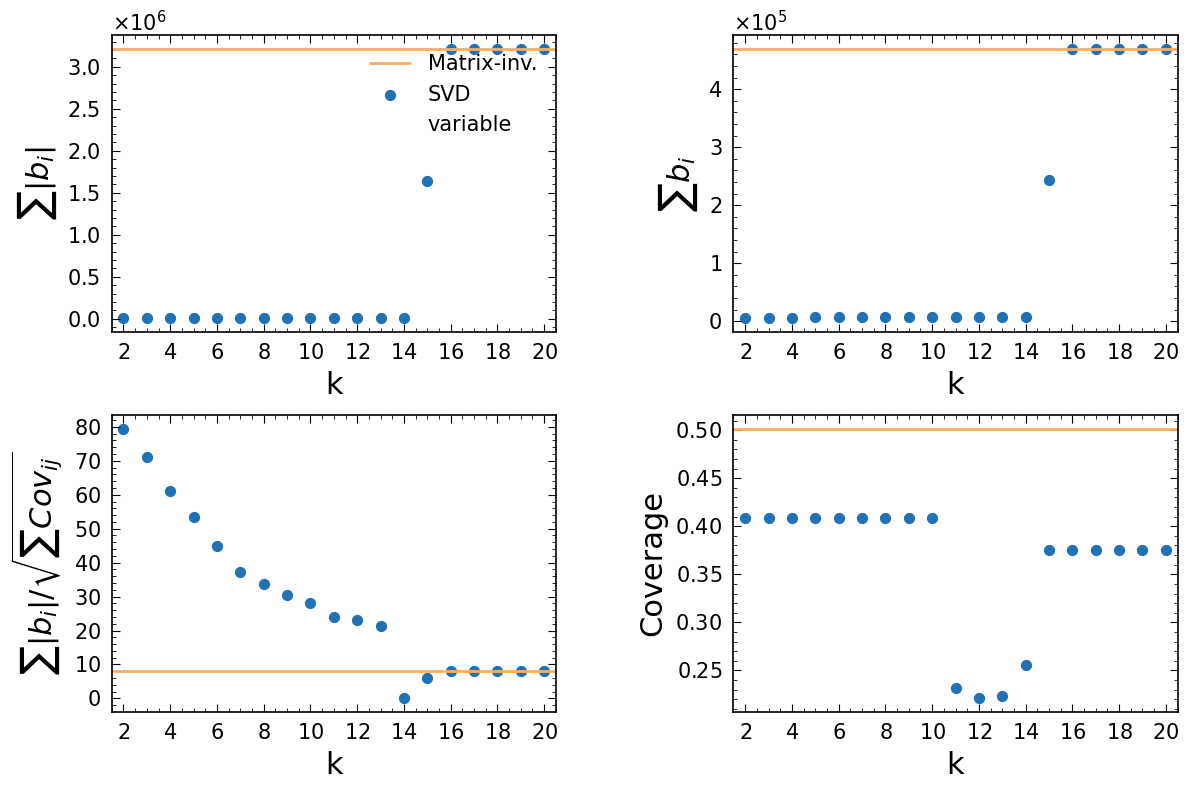

In [73]:
# compare the result
# User can define own plotting function
# Some examples can be found in ./plotting.py

plot_unf_fom_my(k_arr, svd_fom, inv_fom, example_toy.show_var, leg=1) 

<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\s'
/var/folders/38/lc2tk_jj1jx2qmw14bccxk740000gn/T/ipykernel_97193/3707630415.py:5: SyntaxWarning: invalid escape sequence '\s'
  fom_names = ['$\sum_{i}{|b_{i}|}$',
/var/folders/38/lc2tk_jj1jx2qmw14bccxk740000gn/T/ipykernel_97193/3707630415.py:6: SyntaxWarning: invalid escape sequence '\s'
  '$\sum_{i}{|b_{i}|/N_{i}^{true}}$',
/var/folders/38/lc2tk_jj1jx2qmw14bccxk740000gn/T/ipykernel_97193/3707630415.py:7: SyntaxWarning: invalid escape sequence '\s'
  '$\sqrt{\sum_{i,j}Cov_{i,j}}$',
/var/folders

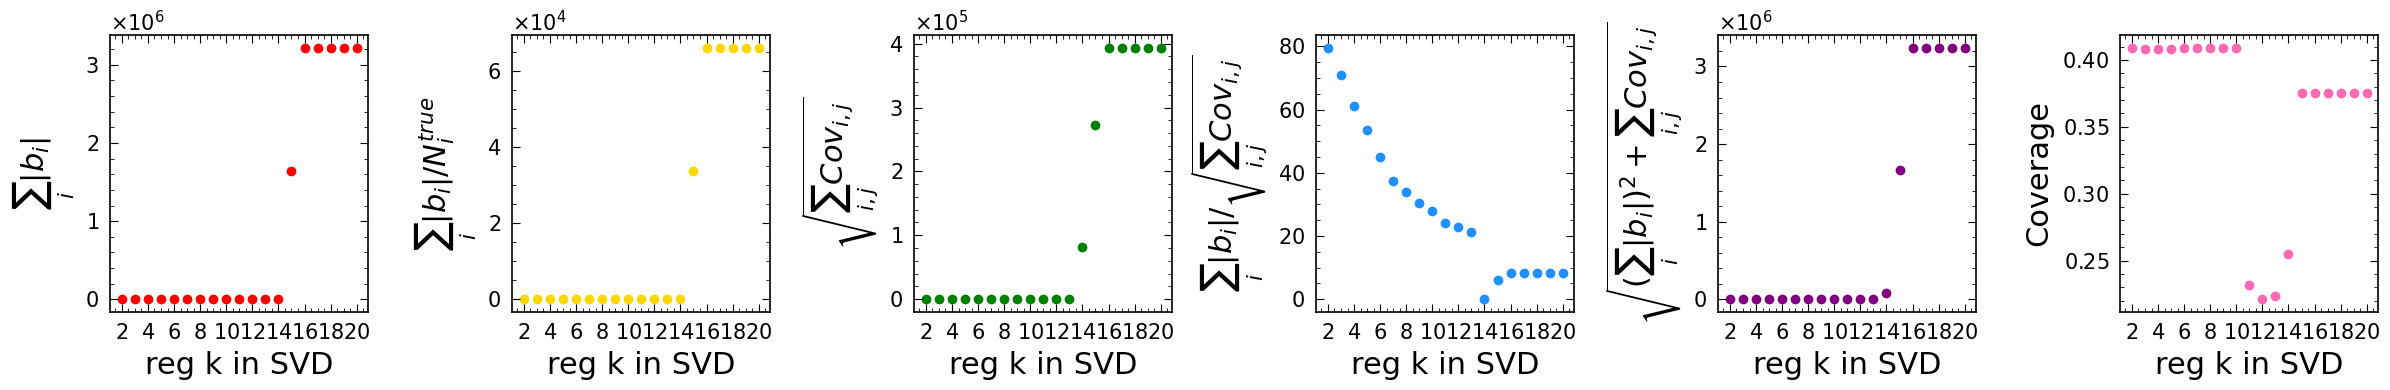

In [74]:
foms    = [svd_fom['fom_a'], svd_fom['fom_b'], svd_fom['fom_d'], svd_fom['fom_e'], svd_fom['fom_f'],svd_fom['fom_h']]

colors    = ['red', 'gold', 'green', 'dodgerblue', 'purple', 'hotpink']

fom_names = ['$\sum_{i}{|b_{i}|}$', 
             '$\sum_{i}{|b_{i}|/N_{i}^{true}}$',
             '$\sqrt{\sum_{i,j}Cov_{i,j}}$',
             '$\sum_{i}{|b_{i}|}/\sqrt{\sum_{i,j}Cov_{i,j}}$', 
             '$\sqrt{(\sum_{i}{|b_{i}|})^{2} + \sum_{i,j}Cov_{i,j}}$', 'Coverage' ]

last_k = 40

# plot until last_k
fig_svd_para = plot_compare_para(len(foms), k_arr, 'reg k in SVD', foms, fom_names, colors, 'variable', last_k)
fig_svd_para.savefig('svd_fom.pdf')

In the reality, it would be better to have a look at the response matrix (migration matrix) before actual unfolding, e.g. to get some feeling to improve the binning, where the guidelines include avoiding low stat. bin and bin_width << resolution.

/Users/guangyongfu/Software/PyRooUnfold/example/rootenv/lib/python3.12/site-packages/pyroounfold/plotting.py:190: RuntimeWarning: invalid value encountered in divide
  mig_matrix = n_matrix/np.expand_dims(x, axis=0)


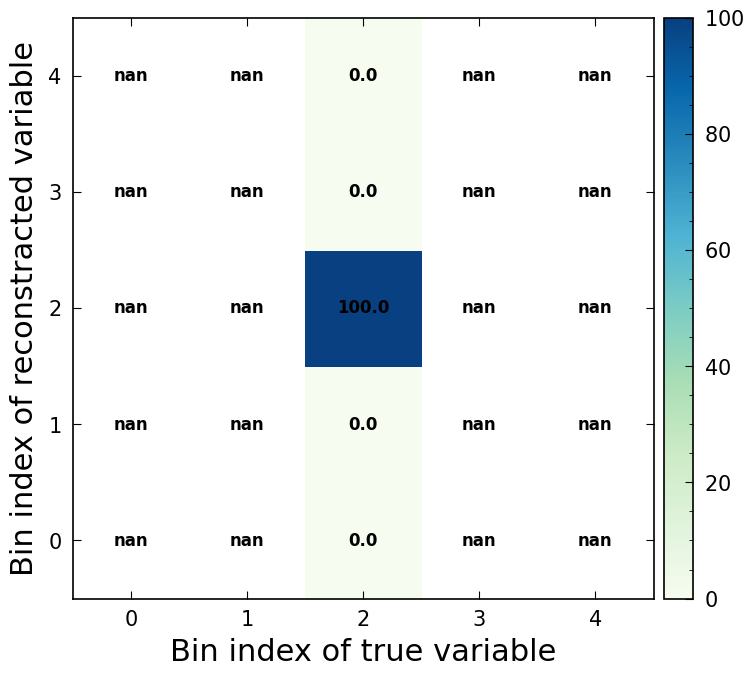

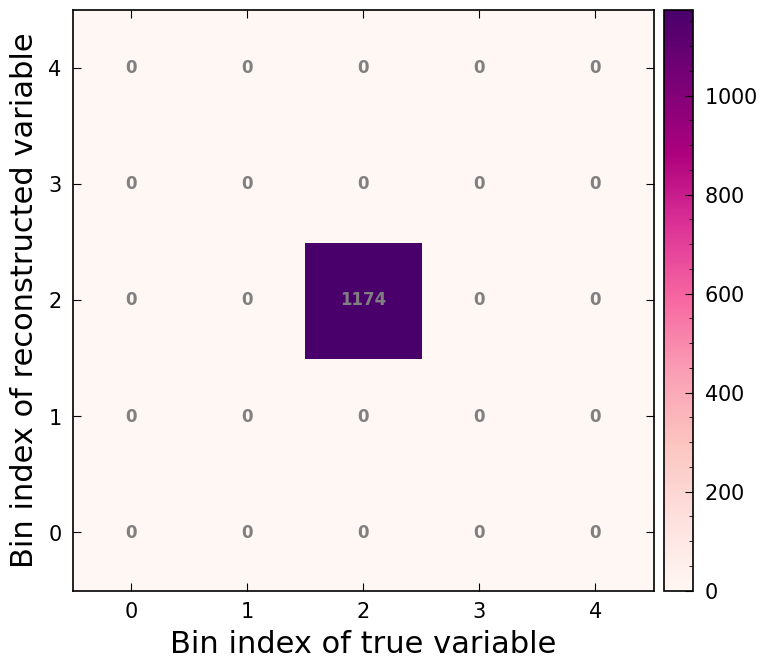

In [75]:
# plot migration matrix and entries matrix

mig_matrix, hist, mig_fig, n_fig = get_migration(
    true_data =df_train['truth'], 
    reco_data =df_train['measured'], 
    weight    =df_train['weight'], 
    bin_var   =np.linspace(-10,10,6), 
    name_var  ='variable')

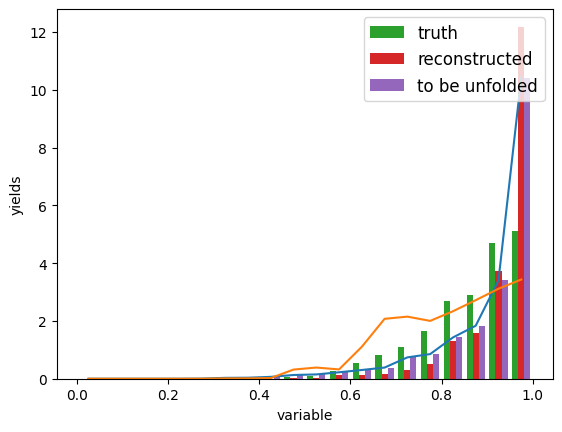

In [76]:
plt.plot((my_bins[:-1] + my_bins[1:])/2,example_a.result_df['measured_central']/np.sum(example_a.result_df['measured_central'])*20)
plt.plot((my_bins[:-1] + my_bins[1:])/2,example_a.result_df['unfolded_central']/np.sum(example_a.result_df['unfolded_central'])*20)
plt.hist([df_train['truth'], df_train['measured'], df_test['measured']], 
         label=['truth', 'reconstructed', 'to be unfolded'], bins = my_bins, density=True )
plt.xlabel('variable')
plt.ylabel('yields')
plt.legend(loc='upper right', prop={'size':12})

[0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75
 0.8  0.85 0.9  0.95 1.  ]


/var/folders/38/lc2tk_jj1jx2qmw14bccxk740000gn/T/ipykernel_97193/4065513089.py:18: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  plt.plot(x,Spec/np.trapz(Spec,x)*x,color="r",ls="-",label="SUPL")


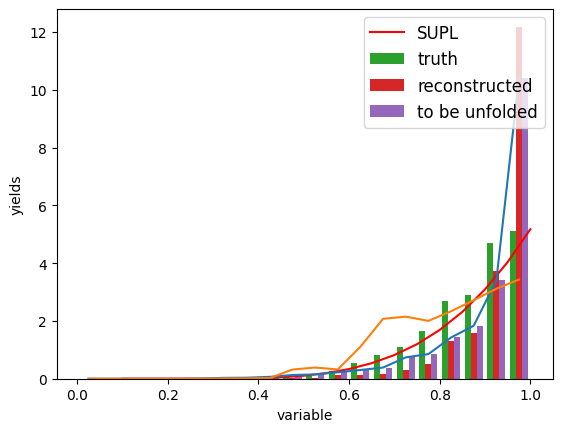

In [77]:
def Angular_intensity(x,h):
    I1= 8.6e-6
    lambda1=0.45
    I2=0.44e-6
    lambda2=0.87
    return  (I1*np.exp(-h/lambda1/x) + I2*np.exp(-h/lambda2/x))/x

def tot_intensity(h):
    I1= 67.97e-6
    lambda1=0.285
    I2=2.071e-6
    lambda2=0.698
    return  I1*np.exp(-h/lambda1) + I2*np.exp(-h/lambda2)

x=np.arange(0.1,1.05,0.05)
print(x)
Spec=Angular_intensity(x,2.88)/(2*np.pi*0.01*sum(Angular_intensity(x,2.88)))*tot_intensity(2.88)
plt.plot(x,Spec/np.trapz(Spec,x)*x,color="r",ls="-",label="SUPL")

plt.plot((my_bins[:-1] + my_bins[1:])/2,example_a.result_df['measured_central']/np.sum(example_a.result_df['measured_central'])*20)
plt.plot((my_bins[:-1] + my_bins[1:])/2,example_a.result_df['unfolded_central']/np.sum(example_a.result_df['unfolded_central'])*20)
plt.hist([df_train['truth'], df_train['measured'], df_test['measured']], 
         label=['truth', 'reconstructed', 'to be unfolded'], bins = my_bins, density=True )
plt.xlabel('variable')
plt.ylabel('yields')
plt.legend(loc='upper right', prop={'size':12})